In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from time import time

# Data

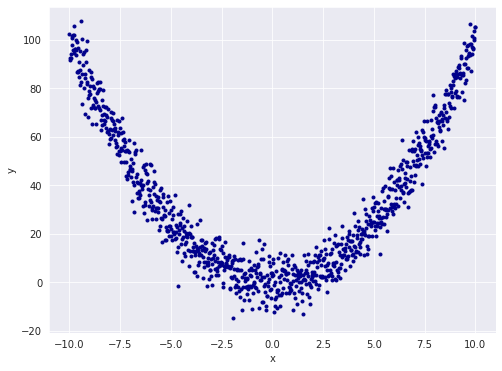

In [0]:
x = np.linspace(-10,10,1000) 
y = [(i**2)+6*np.random.randn() for i in x] #f1
#y = [5/(1+i**2)+0.1*np.random.randn() for i in x] #f2
#y = [2/(1+np.exp(-i))+0.1*np.random.randn() for i in x] #f3

data = pd.DataFrame({'x':x,'y':y})

def graficar(x,y):
    sns.set_style("darkgrid")
    plt.figure(figsize=(8,6))
    plt.plot(x,y,'.',c='darkblue')
    plt.axis('auto')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

graficar(data['x'],data['y'])

In [0]:
train_dataset = data.sample(frac=0.7,random_state=0)
test_dataset = data.drop(train_dataset.index)

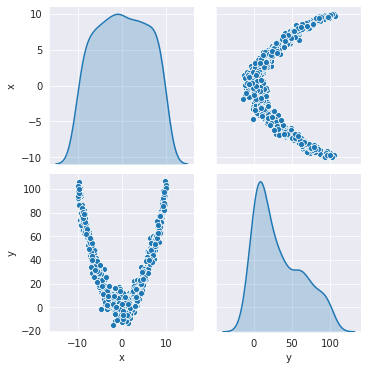

In [0]:
sns.pairplot(train_dataset, diag_kind="kde")

In [0]:
train_labels = train_dataset.pop('y')
test_labels = test_dataset.pop('y')

## Normalización

In [0]:
scaler = StandardScaler().fit(train_dataset)
normed_train_data = scaler.transform(train_dataset)
normed_test_data = scaler.transform(test_dataset)

# Modelo

In [0]:
def build_model():
  neuronas = 64
  model = keras.Sequential([
    layers.Dense(neuronas, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


# Entrenamiento

In [0]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000
# Early stop
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(),early_stop])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................................

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
456,37.171452,4.915323,37.171452,39.312675,5.104557,39.312675,456
457,37.166767,4.922211,37.166767,39.414948,5.112226,39.414948,457
458,37.178421,4.921847,37.178421,39.329327,5.104355,39.329327,458
459,37.150406,4.917658,37.150406,39.222519,5.096543,39.222519,459
460,37.163647,4.918626,37.163647,39.148922,5.090975,39.148922,460


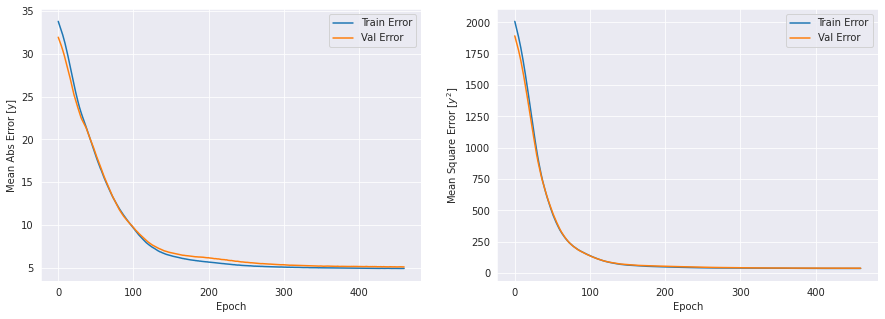

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  fig, axs = plt.subplots(1,2,figsize=(15,5)) 
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Mean Abs Error [y]')
  axs[0].plot(hist['epoch'], hist['mae'],
           label='Train Error')
  axs[0].plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  axs[0].legend()

  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Mean Square Error [$y^2$]')
  axs[1].plot(hist['epoch'], hist['mse'],
           label='Train Error')
  axs[1].plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  axs[1].legend()
  plt.show()

plot_history(history)

# Predicciones

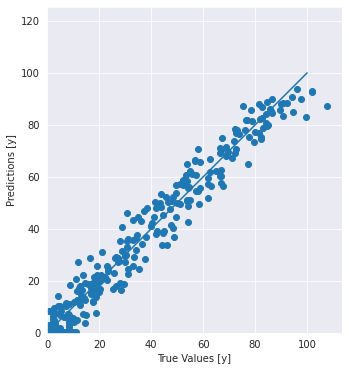

In [0]:
test_predictions = model.predict(normed_test_data).flatten()
train_predictions = model.predict(normed_train_data).flatten()

plt.figure(figsize=(6,6))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [y]')
plt.ylabel('Predictions [y]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

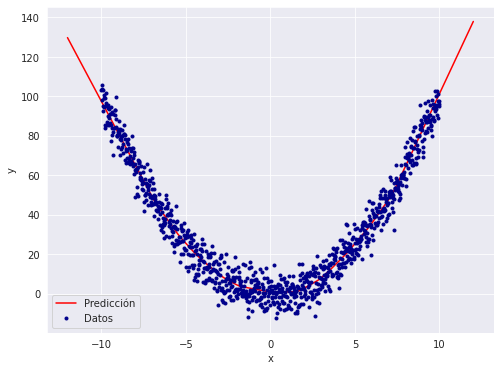

In [0]:
x2 = np.linspace(-12,12,100)
x2_norm = np.array([norm(i) for i in x2])

predictions = model.predict(x2_norm)


sns.set_style("darkgrid")
plt.figure(figsize=(8,6))
plt.plot(x2,predictions,'-',c='red')
plt.plot(data['x'],data['y'],'.',c='darkblue')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(('Predicción','Datos'))
plt.axis('auto')
plt.show()

# Errores

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [y]")
_ = plt.ylabel("Count")

In [0]:
mse = mean_squared_error(test_labels, test_predictions)
print('Mean Squared Error:',mse)
mae = mean_absolute_error(test_labels, test_predictions)
print('Mean Absolute Error:',mae)
rsq = r2_score(train_labels,train_predictions) #R-Squared on the training data
print('R-square, Training:',rsq)
rsq = r2_score(test_labels,test_predictions) #R-Squared on the testing data
print('R-square, Testing:',rsq)

# Automatización

In [0]:
def build_model(neuronas,i):
    model = keras.Sequential(layers.Dense(neuronas, activation='relu', input_shape=[len(train_dataset.keys())]))
    for k in range(i-1):
        model.add(layers.Dense(2**p, activation="relu"))

    model.add(layers.Dense(1))

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

p1 = 5
p2 = 6
EPOCHS = 1000

lista_neuronas_totales = []
lista_neuronas = []
lista_capas = []
lista_mse = []
lista_mae = []
lista_r_training = []
lista_r_test = []
lista_tiempo = []
lista_parametros = []
lista_prop = []
lista_epocas = []

for p in range(p1,p2+1):
    i = 1
    while p > 0:
        model = build_model(2**p,i)
        #model.summary()

        # Entrenamiento
        # Tomamos el tiempo de entrenamiento
        start_time = time()
        # Early stop
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
        history = model.fit(
            normed_train_data, train_labels,
            epochs=EPOCHS, validation_split = 0.2, verbose=0,callbacks=[early_stop])
        time_ex = time() - start_time

        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch
        test_predictions = model.predict(normed_test_data).flatten()
        train_predictions = model.predict(normed_train_data).flatten()

        print('Capas:',i,'\nNeuronas x Capa:',2**p,'\nEpocas:',len(history.epoch))
        mse = mean_squared_error(test_labels, test_predictions)
        #print('Mean Squared Error:',mse)
        mae = mean_absolute_error(test_labels, test_predictions)
        #print('Mean Absolute Error:',mae)
        rsq_train = r2_score(train_labels,train_predictions) #R-Squared on the training data
        #print('R-square, Training:',rsq_train)
        rsq_test = r2_score(test_labels,test_predictions) #R-Squared on the testing data
        print('R-square, Testing:',rsq_test)
        print('---------------------------------------')
        # Agregamos datos del entrenamiento

        lista_neuronas.append(2**p)
        lista_capas.append(i)
        lista_neuronas_totales.append(i*(2**p))
        lista_parametros.append(model.count_params())
        lista_mse.append(mse)
        lista_mae.append(mae)
        lista_r_training.append(rsq_train)
        lista_r_test.append(rsq_test)
        lista_tiempo.append(time_ex)
        lista_prop.append(model.count_params()/len(train_labels))
        lista_epocas.append(len(history.epoch))

        i = 2*i
        p = p-1

Capas: 1 
Neuronas x Capa: 32 
Epocas: 556
R-square, Testing: 0.9539082037938283
---------------------------------------
Capas: 2 
Neuronas x Capa: 16 
Epocas: 256
R-square, Testing: 0.9516958388183906
---------------------------------------
Capas: 4 
Neuronas x Capa: 8 
Epocas: 79
R-square, Testing: 0.9385903886150295
---------------------------------------
Capas: 8 
Neuronas x Capa: 4 
Epocas: 181
R-square, Testing: 0.9553337249502227
---------------------------------------
Capas: 16 
Neuronas x Capa: 2 
Epocas: 1000
R-square, Testing: -0.3203574714816533
---------------------------------------
Capas: 1 
Neuronas x Capa: 64 
Epocas: 362
R-square, Testing: 0.9563520397240419
---------------------------------------
Capas: 2 
Neuronas x Capa: 32 
Epocas: 170
R-square, Testing: 0.9568611408927928
---------------------------------------
Capas: 4 
Neuronas x Capa: 16 
Epocas: 143
R-square, Testing: 0.9579143042792825
---------------------------------------
Capas: 8 
Neuronas x Capa: 8 
Epo

## Tabla

In [0]:
df = pd.DataFrame({'Neuronas':lista_neuronas_totales,
                   'Neuronas x Capa':lista_neuronas,
                   'Capas':lista_capas,
                   'Parametros':lista_parametros,
                   'PAR/TRAIN':lista_prop,
                   'MSE':lista_mse,
                   'MAE':lista_mae,
                   'RSQ TRAIN':lista_r_training,
                   'RSQ TEST':lista_r_test,
                   'Tiempo':lista_tiempo,
                   'Epocas':lista_epocas})
df.to_excel('data_model_simple.xlsx',index=False)
df

,Neuronas,Neuronas x Capa,Capas,Parametros,PAR/TRAIN,MSE,MAE,RSQ TRAIN,RSQ TEST,Tiempo,Epocas
0,32,32,1,97,0.138571,39.437596,5.006982,0.959524,0.953908,26.439399,556
1,32,16,2,321,0.458571,41.330566,5.108858,0.957489,0.951696,13.216969,256
2,32,8,4,241,0.344286,52.544003,5.773912,0.944479,0.938590,4.701550,79
3,32,4,8,153,0.218571,38.217875,4.932964,0.961238,0.955334,10.601942,181
4,32,2,16,97,0.138571,1129.739547,25.773904,-0.254283,-0.320357,61.915034,1000
5,64,64,1,193,0.275714,37.346573,4.891178,0.960496,0.956352,18.167871,362
6,64,32,2,1153,1.647143,36.910970,4.871086,0.961251,0.956861,9.349726,170
7,64,16,4,865,1.235714,36.009850,4.793134,0.961779,0.957914,7.981790,143
8,64,8,8,529,0.755714,38.275700,4.972963,0.960775,0.955266,8.316305,135
9,64,4,16,313,0.447143,862.358804,24.609282,-0.002554,-0.007862,19.900959,305


# Segunda variación

In [0]:
def build_model_2(n,i):
    neuronas = (n-i+1)*(n-i+1+1)/2
    model = keras.Sequential([
      layers.Dense(neuronas, activation='relu', input_shape=[len(train_dataset.keys())]),
    ])
    for k in range(i-1):
        model.add(layers.Dense(n-i+2+k, activation="relu"))

    model.add(layers.Dense(1))

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

EPOCHS = 1000
n = 10
# Cantidad de neuronas = n(n+1)/2
l_neuronas = []
l_capas = []
l_mse = []
l_mae = []
l_r_training = []
l_r_test = []
l_tiempo = []
l_parametros = []
l_prop = []
l_epocas = []

for i in range(n):
    model = build_model_2(n,i+1)
    #model.summary()
    # Entrenamiento
    # Tomamos el tiempo de entrenamiento
    start_time = time()
    # Early stop
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(
        normed_train_data, train_labels,
        epochs=EPOCHS, validation_split = 0.2, verbose=0,callbacks=[early_stop])
    time_ex = time() - start_time
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    test_predictions = model.predict(normed_test_data).flatten()
    train_predictions = model.predict(normed_train_data).flatten()

    print('Capas:',i+1,'\nEpocas:',len(history.epoch))
    mse = mean_squared_error(test_labels, test_predictions)
    #print('Mean Squared Error:',mse)
    mae = mean_absolute_error(test_labels, test_predictions)
    #print('Mean Absolute Error:',mae)
    rsq_train = r2_score(train_labels,train_predictions) #R-Squared on the training data
    print('R-square, Training:',rsq_train)
    rsq_test = r2_score(test_labels,test_predictions) #R-Squared on the testing data
    print('R-square, Testing:',rsq_test)
    print('---------------------------------------')

    # Agregamos datos del entrenamiento
    l_neuronas.append(n*(n+1)/2)
    l_capas.append(i+1)
    l_parametros.append(model.count_params())
    l_mse.append(mse)
    l_mae.append(mae)
    l_r_training.append(rsq_train)
    l_r_test.append(rsq_test)
    l_tiempo.append(time_ex)
    l_prop.append(model.count_params()/len(train_labels))  
    l_epocas.append(len(history.epoch))

## Tabla

In [0]:
df2 = pd.DataFrame({'Capas':l_capas,
                   'Parametros':l_parametros,
                   'PAR/TRAIN':l_prop,
                   'MSE':l_mse,
                   'MAE':l_mae,
                   'RSQ TRAIN':l_r_training,
                   'RSQ TEST':l_r_test,
                   'Tiempo':l_tiempo}},
                   'Epocas':l_epocas})
df2.to_excel('data_model_2_simple.xlsx',index=False)
df2